#Setup Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import pandas
import pandas as pd
import matplotlib.pyplot as plt
# Read Excel file with multiple sheets
xls = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/2. MER PointTransaction 2023_RetailsResellers_Final.xlsx", sheet_name=['MER Transaction', 'Point Per Litre'])

# Access individual sheets using sheet names
MER_df = xls['MER Transaction']
PPL_df = xls['Point Per Litre']

In [ ]:
import datetime

In [ ]:
MER_df.head()

,Invoicedate,Distributor,GroupId,Type,Provincename,MatNo,Material Name,New_Volume(L)
0,2023-09-06,A,ERW_AMBP2020110207,Reseller,Chachoengsao,145577,M SUP Frict Fighter TBS 10W-30 4x7L/CAR,11676
1,2023-12-20,A,ERW_AMBP2020110207,Reseller,Chachoengsao,145577,M SUP Frict Fighter TBS 10W-30 4x7L/CAR,5768
2,2023-08-11,A,ERW_AMBP2020110207,Reseller,Chachoengsao,143160,MOBIL DELVAC SUPER1400 15W-40 4X6+1L/CAR,11088
3,2023-03-10,A,ERW_AMBP2020110291,Reseller,Nakhon Ratchasima,143160,MOBIL DELVAC SUPER 1400 15W-40 4X6+1/CAR,2912
4,2023-03-10,A,ERW_AMBP2020110291,Reseller,Nakhon Ratchasima,143160,MOBIL DELVAC SUPER1400 15W-40 4X6+1L/CAR,7168


In [ ]:
PPL_df.head()

,MatNo,Points
0,144673,10
1,140521,10
2,144473,10
3,145832,10
4,140418,10


In [ ]:
nan_values = MER_df.isnull().sum()

print(nan_values)

Invoicedate      0
Distributor      0
GroupId          0
Type             0
Provincename     0
MatNo            0
Material Name    0
New_Volume(L)    0
dtype: int64


#Feature Engineering

In [ ]:
df = MER_df.merge(PPL_df, on='MatNo', how='left')

In [ ]:
df['Invoicedate'] = pd.to_datetime(df['Invoicedate'])

In [ ]:
df

,Invoicedate,Distributor,GroupId,Type,Provincename,MatNo,Material Name,New_Volume(L),Points
0,2023-09-06,A,ERW_AMBP2020110207,Reseller,Chachoengsao,145577,M SUP Frict Fighter TBS 10W-30 4x7L/CAR,11676,2
1,2023-12-20,A,ERW_AMBP2020110207,Reseller,Chachoengsao,145577,M SUP Frict Fighter TBS 10W-30 4x7L/CAR,5768,2
2,2023-08-11,A,ERW_AMBP2020110207,Reseller,Chachoengsao,143160,MOBIL DELVAC SUPER1400 15W-40 4X6+1L/CAR,11088,2
3,2023-03-10,A,ERW_AMBP2020110291,Reseller,Nakhon Ratchasima,143160,MOBIL DELVAC SUPER 1400 15W-40 4X6+1/CAR,2912,2
4,2023-03-10,A,ERW_AMBP2020110291,Reseller,Nakhon Ratchasima,143160,MOBIL DELVAC SUPER1400 15W-40 4X6+1L/CAR,7168,2
...,...,...,...,...,...,...,...,...,...
9424,2023-03-11,C,ERW_C08P2020090135,Retails,Lampang,140417,"MOBIL 1 TURBO DIESEL 5W-40, 12X1LT CTN",281,10
9425,2023-07-18,C,ERW_C08P2020090145,Retails,Chiang Mai,140417,"MOBIL 1 TURBO DIESEL 5W-40, 12X1LT CTN",354,10
9426,2023-10-19,C,ERW_C08P2020090203,Retails,Chiang Mai,140635,"MOBIL 1 FS X2 5W50, 12X1L CTN",281,10
9427,2023-11-29,C,ERW_C08P2020090203,Retails,Chiang Mai,140635,"MOBIL 1 FS X2 5W50, 12X1L CTN",162,10


In [ ]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


In [ ]:
data = pd.DataFrame(df['GroupId'].unique())
data.columns = ['GroupId']
data

,GroupId
0,ERW_AMBP2020110207
1,ERW_AMBP2020110291
2,ERW_BM2U2020110053
3,ERW_C08P2020090096
4,ERW_BM2U2020110177
...,...
632,ERW_AMBP2020110762
633,ERW_C08P2020090018
634,ERW_C08P2020090132
635,ERW_C9H62020120015


In [ ]:
df_Q1 = df.loc[df['Invoicedate'].dt.quarter == 1]
tx_max_purchase_Q1 = df_Q1.groupby('GroupId').Invoicedate.max().reset_index()
tx_max_purchase_Q1.columns = ['GroupId','MaxPurchaseDate_Q1']
tx_max_purchase_Q1['Recency_Q1'] = (datetime.datetime(2023, 3, 31) - tx_max_purchase_Q1['MaxPurchaseDate_Q1']).dt.days
data = pd.merge(data, tx_max_purchase_Q1, on='GroupId', how='left')
data['Recency_Q1'].fillna((datetime.datetime(2023, 3, 31) - datetime.datetime(2023, 1, 1)).days,inplace=True)

df_Q2 = df.loc[df['Invoicedate'].dt.quarter == 2]
tx_max_purchase_Q2 = df_Q2.groupby('GroupId').Invoicedate.max().reset_index()
tx_max_purchase_Q2.columns = ['GroupId','MaxPurchaseDate_Q2']
tx_max_purchase_Q2['Recency_Q2'] = (datetime.datetime(2023, 6, 30) - tx_max_purchase_Q2['MaxPurchaseDate_Q2']).dt.days
data = pd.merge(data, tx_max_purchase_Q2, on='GroupId', how='left')
data['Recency_Q2'].fillna((datetime.datetime(2023, 6, 30) - datetime.datetime(2023, 4, 1)).days,inplace=True)

df_Q3 = df.loc[df['Invoicedate'].dt.quarter == 3]
tx_max_purchase_Q3 = df_Q3.groupby('GroupId').Invoicedate.max().reset_index()
tx_max_purchase_Q3.columns = ['GroupId','MaxPurchaseDate_Q3']
tx_max_purchase_Q3['Recency_Q3'] = (datetime.datetime(2023, 9, 30) - tx_max_purchase_Q3['MaxPurchaseDate_Q3']).dt.days
data = pd.merge(data, tx_max_purchase_Q3, on='GroupId', how='left')
data['Recency_Q3'].fillna((datetime.datetime(2023, 9, 30) - datetime.datetime(2023, 7, 1)).days,inplace=True)

df_Q4 = df.loc[df['Invoicedate'].dt.quarter == 4]
tx_max_purchase_Q4 = df_Q4.groupby('GroupId').Invoicedate.max().reset_index()
tx_max_purchase_Q4.columns = ['GroupId','MaxPurchaseDate_Q4']
tx_max_purchase_Q4['Recency_Q4'] = (datetime.datetime(2023, 12, 31) - tx_max_purchase_Q4['MaxPurchaseDate_Q4']).dt.days
data = pd.merge(data, tx_max_purchase_Q4, on='GroupId', how='left')
data['Recency_Q4'].fillna((datetime.datetime(2023, 12, 31) - datetime.datetime(2023, 10, 1)).days,inplace=True)
data['Recency'] = (data['Recency_Q1'] + data['Recency_Q2'] + data['Recency_Q3'] + data['Recency_Q4'])/4
data = data.drop(['Recency_Q1', 'Recency_Q2', 'Recency_Q3', 'Recency_Q4', 'MaxPurchaseDate_Q1', 'MaxPurchaseDate_Q2', 'MaxPurchaseDate_Q3', 'MaxPurchaseDate_Q4'], axis=1)
data

,GroupId,Recency
0,ERW_AMBP2020110207,3.50
1,ERW_AMBP2020110291,33.50
2,ERW_BM2U2020110053,6.50
3,ERW_C08P2020090096,13.00
4,ERW_BM2U2020110177,1.75
...,...,...
632,ERW_AMBP2020110762,52.25
633,ERW_C08P2020090018,76.75
634,ERW_C08P2020090132,62.25
635,ERW_C9H62020120015,78.75


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

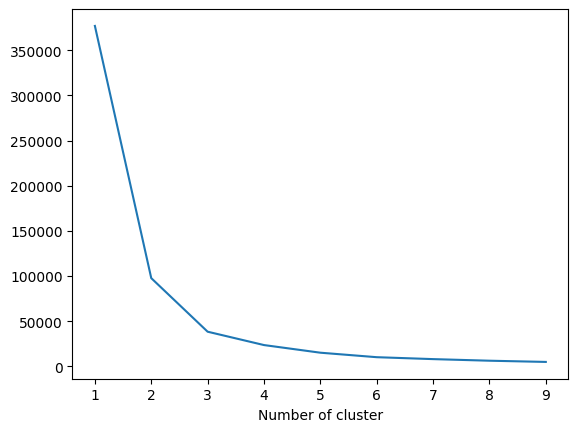

In [ ]:
from sklearn.cluster import KMeans
sse={}
tx_Recency = data[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_Recency)
    tx_Recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [ ]:
# Applying k-Means
kmeans=KMeans(n_clusters=4)
data['RecencyCluster']=kmeans.fit_predict(data[['Recency']])

#order the frequency cluster
data = order_cluster('RecencyCluster', 'Recency', data, False )
data.groupby('RecencyCluster')['Recency'].describe()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,231.0,76.357143,6.316399,65.50,70.500,76.000,80.875,89.75
1,148.0,54.253378,5.690575,45.00,49.750,53.875,58.250,65.25
2,139.0,35.442446,6.075261,24.50,30.500,36.250,41.000,44.75
3,119.0,13.224790,6.118826,1.75,8.625,13.250,17.750,24.25


In [ ]:
#get order counts for each user and create a dataframe with it
tx_frequency = df.groupby('GroupId').Invoicedate.count().reset_index()
tx_frequency.columns = ['GroupId','Frequency']
tx_frequency

,GroupId,Frequency
0,ERW_A1DS2023040002,7
1,ERW_A1DS2023040003,2
2,ERW_A1DS2023040005,27
3,ERW_A1T02022040001,1
4,ERW_A2JJ2023070001,12
...,...,...
632,ERW_DGVG2021110003,31
633,ERW_DJAK2021020001,1
634,ERW_DLD72021010006,3
635,ERW_DLD72021010008,12


In [ ]:
tx_frequency.sort_values(by='Frequency', ascending=False)

,GroupId,Frequency
71,ERW_AMBP2020110030,325
593,ERW_DBG72020110038,223
472,ERW_C08P2020090127,165
308,ERW_BM2U2020110053,165
382,ERW_BXEO2021030002,162
...,...,...
186,ERW_AMBP2020110503,1
53,ERW_AI8N2021070006,1
52,ERW_AI8N2021070003,1
548,ERW_CGAA2021010002,1


In [ ]:
data = pd.merge(data, tx_frequency, on='GroupId')
data

,GroupId,Recency,RecencyCluster,Frequency
0,ERW_AMBP2020110207,3.50,3,154
1,ERW_BM2U2020110053,6.50,3,165
2,ERW_C08P2020090096,13.00,3,21
3,ERW_BM2U2020110177,1.75,3,130
4,ERW_ADG22021040108,21.25,3,9
...,...,...,...,...
632,ERW_BM2U2020110001,84.25,0,1
633,ERW_BXEO2021030007,78.00,0,1
634,ERW_AMBP2020110732,73.75,0,1
635,ERW_C08P2020090018,76.75,0,3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-18-9cd8d0324290>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_frequency["clusters"] = kmeans.labels_
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-18-9cd8d0324290>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

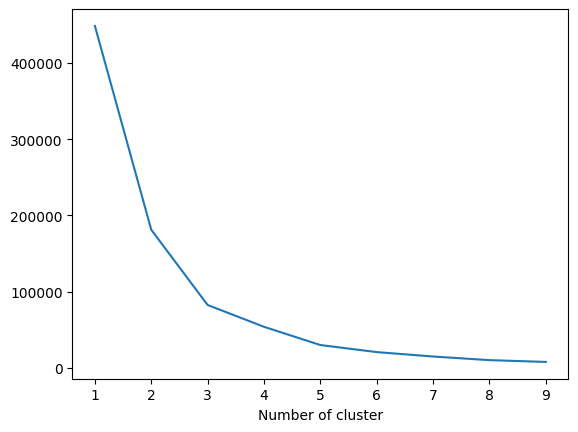

In [ ]:
from sklearn.cluster import KMeans

sse={}
tx_frequency = data[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [ ]:
# Applying k-Means
kmeans=KMeans(n_clusters=4)
data['FrequencyCluster']=kmeans.fit_predict(data[['Frequency']])

#order the frequency cluster
data = order_cluster('FrequencyCluster', 'Frequency', data, True )
data.groupby('FrequencyCluster')['Frequency'].describe()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,475.0,5.193684,3.964553,1.0,2.0,4.0,8.0,15.0
1,118.0,25.576271,8.088619,16.0,19.0,24.0,31.0,46.0
2,35.0,66.542857,16.448391,48.0,53.5,62.0,74.5,112.0
3,9.0,179.444444,60.479565,130.0,151.0,162.0,165.0,325.0


In [ ]:
data

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster
0,ERW_AMBP2020110207,3.50,3,154,3
1,ERW_BM2U2020110053,6.50,3,165,3
2,ERW_BM2U2020110177,1.75,3,130,3
3,ERW_DBG72020110038,4.00,3,223,3
4,ERW_AMBP2020110030,4.75,3,325,3
...,...,...,...,...,...
632,ERW_BM2U2020110077,9.75,3,98,2
633,ERW_BM2U2020110034,2.00,3,60,2
634,ERW_AMBP2020110060,7.25,3,95,2
635,ERW_AMBP2020110380,28.50,2,64,2


In [ ]:
df['Revenue'] = df['New_Volume(L)'] * df['Points']
tx_revenue = df.groupby('GroupId').Revenue.sum().reset_index()
tx_revenue

,GroupId,Revenue
0,ERW_A1DS2023040002,80524
1,ERW_A1DS2023040003,14840
2,ERW_A1DS2023040005,263228
3,ERW_A1T02022040001,18480
4,ERW_A2JJ2023070001,91950
...,...,...
632,ERW_DGVG2021110003,286710
633,ERW_DJAK2021020001,23632
634,ERW_DLD72021010006,60312
635,ERW_DLD72021010008,101740


In [ ]:
#merge it with our main dataframe
data = pd.merge(data, tx_revenue, on='GroupId')
data

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,ERW_AMBP2020110207,3.50,3,154,3,2124170
1,ERW_BM2U2020110053,6.50,3,165,3,1779038
2,ERW_BM2U2020110177,1.75,3,130,3,1764398
3,ERW_DBG72020110038,4.00,3,223,3,2188248
4,ERW_AMBP2020110030,4.75,3,325,3,5740639
...,...,...,...,...,...,...
632,ERW_BM2U2020110077,9.75,3,98,2,935518
633,ERW_BM2U2020110034,2.00,3,60,2,615680
634,ERW_AMBP2020110060,7.25,3,95,2,2609592
635,ERW_AMBP2020110380,28.50,2,64,2,1358300


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-23-57f5b7d8310b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_revenue["clusters"] = kmeans.labels_
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-23-57f5b7d8310b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

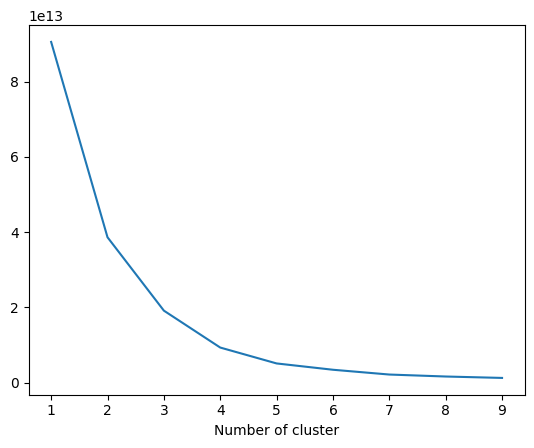

In [ ]:
sse={} # error
tx_revenue = data[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [ ]:
#apply clustering
kmeans = KMeans(n_clusters=4)
data['RevenueCluster'] = kmeans.fit_predict(data[['Revenue']])

#order the cluster numbers
data = order_cluster('RevenueCluster', 'Revenue',data,True)

#show details of the dataframe
data.groupby('RevenueCluster')['Revenue'].describe()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,550.0,8.544662e+04,81513.843882,128.0,23250.0,54634.0,128028.0,326842.0
1,70.0,5.691293e+05,204164.055803,331764.0,401949.5,508619.0,708181.0,1095776.0
2,16.0,1.656126e+06,429206.081779,1158730.0,1342776.5,1544882.5,1865321.0,2609592.0
3,1.0,5.740639e+06,NaN,5740639.0,5740639.0,5740639.0,5740639.0,5740639.0


In [ ]:
data

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,ERW_AMBP2020110207,3.50,3,154,3,2124170,2
1,ERW_BM2U2020110053,6.50,3,165,3,1779038,2
2,ERW_BM2U2020110177,1.75,3,130,3,1764398,2
3,ERW_DBG72020110038,4.00,3,223,3,2188248,2
4,ERW_C08P2020090056,5.25,3,151,3,1158730,2
...,...,...,...,...,...,...,...
632,ERW_BM2U2020110041,11.75,3,52,2,552492,1
633,ERW_BM2U2020110075,13.00,3,53,2,784076,1
634,ERW_BM2U2020110077,9.75,3,98,2,935518,1
635,ERW_BM2U2020110034,2.00,3,60,2,615680,1


In [ ]:
#calculate overall score and use mean() to see details
data['OverallScore'] = data['RecencyCluster'] + data['FrequencyCluster'] + data['RevenueCluster']
data.groupby('OverallScore')[['Recency','Frequency','Revenue']].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,76.380482,2.570175,3.353002e+04
1,54.790146,6.474453,7.480414e+04
2,38.292500,10.040000,1.144986e+05
3,29.266949,18.305085,2.138747e+05
4,19.338889,24.622222,3.087558e+05
5,15.080000,34.720000,5.390568e+05
6,13.462963,61.814815,6.985587e+05
7,6.321429,87.428571,1.696728e+06
8,3.937500,161.250000,1.657828e+06


In [ ]:
data['Segment'] = 'Low-Value'
data.loc[data['OverallScore']>2,'Segment'] = 'Mid-Value'
data.loc[data['OverallScore']>5,'Segment'] = 'High-Value'

In [ ]:
data

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,ERW_AMBP2020110207,3.50,3,154,3,2124170,2,8,High-Value
1,ERW_BM2U2020110053,6.50,3,165,3,1779038,2,8,High-Value
2,ERW_BM2U2020110177,1.75,3,130,3,1764398,2,8,High-Value
3,ERW_DBG72020110038,4.00,3,223,3,2188248,2,8,High-Value
4,ERW_C08P2020090056,5.25,3,151,3,1158730,2,8,High-Value
...,...,...,...,...,...,...,...,...,...
632,ERW_BM2U2020110041,11.75,3,52,2,552492,1,6,High-Value
633,ERW_BM2U2020110075,13.00,3,53,2,784076,1,6,High-Value
634,ERW_BM2U2020110077,9.75,3,98,2,935518,1,6,High-Value
635,ERW_BM2U2020110034,2.00,3,60,2,615680,1,6,High-Value


In [ ]:
segment_mapping = {"High-Value": 2, "Mid-Value": 1, "Low-Value": 0}

data["Segment"] = data["Segment"].map(segment_mapping)

In [ ]:
data

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,ERW_AMBP2020110207,3.50,3,154,3,2124170,2,8,2
1,ERW_BM2U2020110053,6.50,3,165,3,1779038,2,8,2
2,ERW_BM2U2020110177,1.75,3,130,3,1764398,2,8,2
3,ERW_DBG72020110038,4.00,3,223,3,2188248,2,8,2
4,ERW_C08P2020090056,5.25,3,151,3,1158730,2,8,2
...,...,...,...,...,...,...,...,...,...
632,ERW_BM2U2020110041,11.75,3,52,2,552492,1,6,2
633,ERW_BM2U2020110075,13.00,3,53,2,784076,1,6,2
634,ERW_BM2U2020110077,9.75,3,98,2,935518,1,6,2
635,ERW_BM2U2020110034,2.00,3,60,2,615680,1,6,2


In [ ]:
data.value_counts('Segment')

Segment
0    465
1    129
2     43
Name: count, dtype: int64

In [ ]:
data.set_index('GroupId', inplace=True)

In [ ]:
data

,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
GroupId,,,,,,,,
ERW_AMBP2020110207,3.50,3,154,3,2124170,2,8,2
ERW_BM2U2020110053,6.50,3,165,3,1779038,2,8,2
ERW_BM2U2020110177,1.75,3,130,3,1764398,2,8,2
ERW_DBG72020110038,4.00,3,223,3,2188248,2,8,2
ERW_C08P2020090056,5.25,3,151,3,1158730,2,8,2
...,...,...,...,...,...,...,...,...
ERW_BM2U2020110041,11.75,3,52,2,552492,1,6,2
ERW_BM2U2020110075,13.00,3,53,2,784076,1,6,2
ERW_BM2U2020110077,9.75,3,98,2,935518,1,6,2


In [ ]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import xgboost as xgb

In [ ]:
X = data.drop(['RecencyCluster','FrequencyCluster','RevenueCluster','OverallScore','Segment'],axis=1)
y = data['Segment']

In [ ]:
X

,Recency,Frequency,Revenue
GroupId,,,
ERW_AMBP2020110207,3.50,154,2124170
ERW_BM2U2020110053,6.50,165,1779038
ERW_BM2U2020110177,1.75,130,1764398
ERW_DBG72020110038,4.00,223,2188248
ERW_C08P2020090056,5.25,151,1158730
...,...,...,...
ERW_BM2U2020110041,11.75,52,552492
ERW_BM2U2020110075,13.00,53,784076
ERW_BM2U2020110077,9.75,98,935518


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train

,Recency,Frequency,Revenue
GroupId,,,
ERW_BM2U2020110136,41.75,19,316316
ERW_AMBP2020110101,52.25,16,99170
ERW_AMBP2020110762,52.25,3,10968
ERW_C08P2020090052,27.25,19,187832
ERW_AHWO2020120009,60.50,7,110716
...,...,...,...
ERW_C08P2020090109,32.25,17,136013
ERW_C08P2020090139,9.25,9,89674
ERW_CM8N2021050003,59.25,4,71008


In [ ]:
X_test

,Recency,Frequency,Revenue
GroupId,,,
ERW_C08P2020090067,62.75,7,25180
ERW_BM2U2020110170,45.75,5,61220
ERW_C08P2020090116,23.50,22,164660
ERW_AMBP2020110737,69.00,4,16892
ERW_CM8N2021050008,80.50,2,39088
...,...,...,...
ERW_BM2U2020110044,32.00,14,151440
ERW_C08P2020090060,69.75,1,6112
ERW_C08P2020090210,34.00,3,38024


In [ ]:
model = xgb.XGBClassifier(max_depth=5,learning_rate=0.1)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       131
           1       0.92      0.98      0.95        47
           2       1.00      1.00      1.00        14

    accuracy                           0.97       192
   macro avg       0.97      0.98      0.98       192
weighted avg       0.98      0.97      0.97       192



#Churn



In [ ]:
df.head()

,Invoicedate,Distributor,GroupId,Type,Provincename,MatNo,Material Name,New_Volume(L),Points,Revenue
0,2023-09-06,A,ERW_AMBP2020110207,Reseller,Chachoengsao,145577,M SUP Frict Fighter TBS 10W-30 4x7L/CAR,11676,2,23352
1,2023-12-20,A,ERW_AMBP2020110207,Reseller,Chachoengsao,145577,M SUP Frict Fighter TBS 10W-30 4x7L/CAR,5768,2,11536
2,2023-08-11,A,ERW_AMBP2020110207,Reseller,Chachoengsao,143160,MOBIL DELVAC SUPER1400 15W-40 4X6+1L/CAR,11088,2,22176
3,2023-03-10,A,ERW_AMBP2020110291,Reseller,Nakhon Ratchasima,143160,MOBIL DELVAC SUPER 1400 15W-40 4X6+1/CAR,2912,2,5824
4,2023-03-10,A,ERW_AMBP2020110291,Reseller,Nakhon Ratchasima,143160,MOBIL DELVAC SUPER1400 15W-40 4X6+1L/CAR,7168,2,14336


In [ ]:
df = df.sort_values(by=['GroupId', 'Invoicedate'])
df['Difdate'] = df.groupby('GroupId')['Invoicedate'].diff().dt.days
df['Difdate'] = df['Difdate'].fillna((df['Invoicedate'] - pd.to_datetime('2023/1/1')).dt.days).astype(int)
df.head()

,Invoicedate,Distributor,GroupId,Type,Provincename,MatNo,Material Name,New_Volume(L),Points,Revenue,Difdate
3180,2023-05-03,A,ERW_A1DS2023040002,Retails,Bangkok,143877,M SUP AIO PROTECTION TBS 5W-30 4X7L/CAR,12544,1,12544,122
3917,2023-05-03,A,ERW_A1DS2023040002,Retails,Bangkok,145826,M SUP AIO Protection 5W-30 4x4+1L/CAR,7160,4,28640,0
7082,2023-07-07,A,ERW_A1DS2023040002,Retails,Bangkok,143874,M SUP AIO PROTECTION TBS 5W-30 12X1L/CAR,2328,1,2328,65
3182,2023-09-26,A,ERW_A1DS2023040002,Retails,Bangkok,143877,M SUP AIO PROTECTION TBS 5W-30 4X7L/CAR,8120,1,8120,81
3918,2023-10-09,A,ERW_A1DS2023040002,Retails,Bangkok,145826,M SUP AIO Protection 5W-30 4x4+1L/CAR,4580,4,18320,13


In [ ]:
# tx_count = df.groupby('GroupId').size().reset_index(name='Count')
# data = pd.merge(data, tx_count, on='GroupId')
# data = data.drop(data[data['Count'] <= 1].index)
# data

In [ ]:
tx_Avg_DifDate = df.groupby('GroupId').Difdate.mean().reset_index()
tx_Avg_DifDate.columns = ['GroupId','Avg_DifDate']
tx_Avg_DifDate

,GroupId,Avg_DifDate
0,ERW_A1DS2023040002,43.714286
1,ERW_A1DS2023040003,89.000000
2,ERW_A1DS2023040005,13.148148
3,ERW_A1T02022040001,327.000000
4,ERW_A2JJ2023070001,29.333333
...,...,...
632,ERW_DGVG2021110003,11.387097
633,ERW_DJAK2021020001,270.000000
634,ERW_DLD72021010006,117.000000
635,ERW_DLD72021010008,27.083333


In [ ]:
data = pd.merge(data, tx_Avg_DifDate, on='GroupId')
data

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Avg_DifDate
0,ERW_AMBP2020110207,3.50,3,154,3,2124170,2,8,2,2.311688
1,ERW_BM2U2020110053,6.50,3,165,3,1779038,2,8,2,2.181818
2,ERW_BM2U2020110177,1.75,3,130,3,1764398,2,8,2,2.784615
3,ERW_DBG72020110038,4.00,3,223,3,2188248,2,8,2,1.582960
4,ERW_C08P2020090056,5.25,3,151,3,1158730,2,8,2,2.344371
...,...,...,...,...,...,...,...,...,...,...
632,ERW_BM2U2020110041,11.75,3,52,2,552492,1,6,2,6.807692
633,ERW_BM2U2020110075,13.00,3,53,2,784076,1,6,2,6.660377
634,ERW_BM2U2020110077,9.75,3,98,2,935518,1,6,2,3.612245
635,ERW_BM2U2020110034,2.00,3,60,2,615680,1,6,2,6.033333


In [ ]:
tx_max_purchase = df.groupby('GroupId').Invoicedate.max().reset_index()
tx_max_purchase.columns = ['GroupId','MaxPurchaseDate']
tx_max_purchase['Recency (Normal)'] = (datetime.datetime(2023, 12, 31) - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_max_purchase

,GroupId,MaxPurchaseDate,Recency (Normal)
0,ERW_A1DS2023040002,2023-11-03,58
1,ERW_A1DS2023040003,2023-06-28,186
2,ERW_A1DS2023040005,2023-12-22,9
3,ERW_A1T02022040001,2023-11-24,37
4,ERW_A2JJ2023070001,2023-12-19,12
...,...,...,...
632,ERW_DGVG2021110003,2023-12-20,11
633,ERW_DJAK2021020001,2023-09-28,94
634,ERW_DLD72021010006,2023-12-18,13
635,ERW_DLD72021010008,2023-11-22,39


In [ ]:
data = pd.merge(data, tx_max_purchase, on='GroupId')
data

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Avg_DifDate,MaxPurchaseDate,Recency (Normal)
0,ERW_AMBP2020110207,3.50,3,154,3,2124170,2,8,2,2.311688,2023-12-23,8
1,ERW_BM2U2020110053,6.50,3,165,3,1779038,2,8,2,2.181818,2023-12-27,4
2,ERW_BM2U2020110177,1.75,3,130,3,1764398,2,8,2,2.784615,2023-12-29,2
3,ERW_DBG72020110038,4.00,3,223,3,2188248,2,8,2,1.582960,2023-12-20,11
4,ERW_C08P2020090056,5.25,3,151,3,1158730,2,8,2,2.344371,2023-12-21,10
...,...,...,...,...,...,...,...,...,...,...,...,...
632,ERW_BM2U2020110041,11.75,3,52,2,552492,1,6,2,6.807692,2023-12-21,10
633,ERW_BM2U2020110075,13.00,3,53,2,784076,1,6,2,6.660377,2023-12-20,11
634,ERW_BM2U2020110077,9.75,3,98,2,935518,1,6,2,3.612245,2023-12-21,10
635,ERW_BM2U2020110034,2.00,3,60,2,615680,1,6,2,6.033333,2023-12-29,2


In [ ]:
data['Churn_Status'] = data['Recency (Normal)'] > (data['Avg_DifDate'] * 3)
data

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Avg_DifDate,MaxPurchaseDate,Recency (Normal),Churn_Status
0,ERW_AMBP2020110207,3.50,3,154,3,2124170,2,8,2,2.311688,2023-12-23,8,True
1,ERW_BM2U2020110053,6.50,3,165,3,1779038,2,8,2,2.181818,2023-12-27,4,False
2,ERW_BM2U2020110177,1.75,3,130,3,1764398,2,8,2,2.784615,2023-12-29,2,False
3,ERW_DBG72020110038,4.00,3,223,3,2188248,2,8,2,1.582960,2023-12-20,11,True
4,ERW_C08P2020090056,5.25,3,151,3,1158730,2,8,2,2.344371,2023-12-21,10,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,ERW_BM2U2020110041,11.75,3,52,2,552492,1,6,2,6.807692,2023-12-21,10,False
633,ERW_BM2U2020110075,13.00,3,53,2,784076,1,6,2,6.660377,2023-12-20,11,False
634,ERW_BM2U2020110077,9.75,3,98,2,935518,1,6,2,3.612245,2023-12-21,10,False
635,ERW_BM2U2020110034,2.00,3,60,2,615680,1,6,2,6.033333,2023-12-29,2,False


In [ ]:
data['Churn_Status'].value_counts()

Churn_Status
False    496
True     141
Name: count, dtype: int64

In [ ]:
data

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Avg_DifDate,MaxPurchaseDate,Recency (Normal),Churn_Status
0,ERW_AMBP2020110207,3.50,3,154,3,2124170,2,8,2,2.311688,2023-12-23,8,True
1,ERW_BM2U2020110053,6.50,3,165,3,1779038,2,8,2,2.181818,2023-12-27,4,False
2,ERW_BM2U2020110177,1.75,3,130,3,1764398,2,8,2,2.784615,2023-12-29,2,False
3,ERW_DBG72020110038,4.00,3,223,3,2188248,2,8,2,1.582960,2023-12-20,11,True
4,ERW_C08P2020090056,5.25,3,151,3,1158730,2,8,2,2.344371,2023-12-21,10,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,ERW_BM2U2020110041,11.75,3,52,2,552492,1,6,2,6.807692,2023-12-21,10,False
633,ERW_BM2U2020110075,13.00,3,53,2,784076,1,6,2,6.660377,2023-12-20,11,False
634,ERW_BM2U2020110077,9.75,3,98,2,935518,1,6,2,3.612245,2023-12-21,10,False
635,ERW_BM2U2020110034,2.00,3,60,2,615680,1,6,2,6.033333,2023-12-29,2,False


#For PowerBI

In [ ]:
data

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Avg_DifDate,MaxPurchaseDate,Recency (Normal),Churn_Status
0,ERW_AMBP2020110207,3.50,3,154,3,2124170,2,8,2,2.311688,2023-12-23,8,True
1,ERW_BM2U2020110053,6.50,3,165,3,1779038,2,8,2,2.181818,2023-12-27,4,False
2,ERW_BM2U2020110177,1.75,3,130,3,1764398,2,8,2,2.784615,2023-12-29,2,False
3,ERW_DBG72020110038,4.00,3,223,3,2188248,2,8,2,1.582960,2023-12-20,11,True
4,ERW_C08P2020090056,5.25,3,151,3,1158730,2,8,2,2.344371,2023-12-21,10,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,ERW_BM2U2020110041,11.75,3,52,2,552492,1,6,2,6.807692,2023-12-21,10,False
633,ERW_BM2U2020110075,13.00,3,53,2,784076,1,6,2,6.660377,2023-12-20,11,False
634,ERW_BM2U2020110077,9.75,3,98,2,935518,1,6,2,3.612245,2023-12-21,10,False
635,ERW_BM2U2020110034,2.00,3,60,2,615680,1,6,2,6.033333,2023-12-29,2,False


In [ ]:
Updategrouped_data = data.drop(['Segment','RecencyCluster','FrequencyCluster','RevenueCluster','Avg_DifDate','MaxPurchaseDate','Recency (Normal)','OverallScore','Revenue','Frequency','Recency'],axis=1)
Updategrouped_data

,GroupId,Churn_Status
0,ERW_AMBP2020110207,True
1,ERW_BM2U2020110053,False
2,ERW_BM2U2020110177,False
3,ERW_DBG72020110038,True
4,ERW_C08P2020090056,True
...,...,...
632,ERW_BM2U2020110041,False
633,ERW_BM2U2020110075,False
634,ERW_BM2U2020110077,False
635,ERW_BM2U2020110034,False


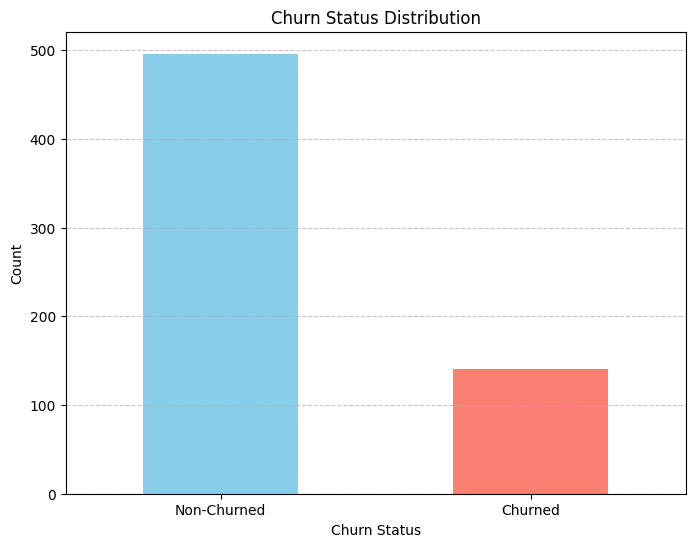

In [ ]:
# Plotting churn status count
churn_counts = Updategrouped_data['Churn_Status'].value_counts()

# Plotting the churn status distribution
plt.figure(figsize=(8, 6))
churn_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Churn Status Distribution')
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Churned', 'Churned'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
Updategrouped_data.to_csv('Re Churn Analysis.csv', index=False)

from google.colab import files
files.download('Re Churn Analysis.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Prepare Data Train

In [ ]:
data.set_index('GroupId', inplace=True)

In [ ]:
X = data.drop(['Segment','RecencyCluster','FrequencyCluster','RevenueCluster','Avg_DifDate','MaxPurchaseDate','Recency (Normal)','Churn_Status'],axis=1)
y = data['Churn_Status']

In [ ]:
X

,Recency,Frequency,Revenue,OverallScore
GroupId,,,,
ERW_AMBP2020110207,3.50,154,2124170,8
ERW_BM2U2020110053,6.50,165,1779038,8
ERW_BM2U2020110177,1.75,130,1764398,8
ERW_DBG72020110038,4.00,223,2188248,8
ERW_C08P2020090056,5.25,151,1158730,8
...,...,...,...,...
ERW_BM2U2020110075,13.00,53,784076,6
ERW_BM2U2020110077,9.75,98,935518,6
ERW_BM2U2020110034,2.00,60,615680,6


In [ ]:
y

GroupId
ERW_AMBP2020110207     True
ERW_BM2U2020110053    False
ERW_BM2U2020110177    False
ERW_DBG72020110038     True
ERW_C08P2020090056     True
                      ...  
ERW_BM2U2020110075    False
ERW_BM2U2020110077    False
ERW_BM2U2020110034    False
ERW_C08P2020090012     True
ERW_AUOF2022100001    False
Name: Churn_Status, Length: 637, dtype: bool

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train

,Recency,Frequency,Revenue,OverallScore
GroupId,,,,
ERW_C08P2020090109,32.25,17,136013,3
ERW_AUTN2021110008,48.00,32,281921,2
ERW_C08P2020090203,47.50,7,35814,1
ERW_DBG72020110083,25.50,17,147216,3
ERW_AMBP2020110282,52.00,14,185636,1
...,...,...,...,...
ERW_C08P2020090052,27.25,19,187832,3
ERW_C08P2020090087,15.75,5,84560,3
ERW_BWW12022040001,55.00,4,46656,1


In [ ]:
X_test

,Recency,Frequency,Revenue,OverallScore
GroupId,,,,
ERW_AMBP2020110196,64.50,2,11394,1
ERW_BH4O2022010003,51.75,8,82492,1
ERW_C08P2020090116,23.50,22,164660,4
ERW_DBG72020110092,89.75,1,5400,0
ERW_CPCI2022060003,71.00,2,4321,0
...,...,...,...,...
ERW_AMBP2020110085,36.25,7,248800,2
ERW_A1T02022040001,76.75,1,18480,0
ERW_C08P2020090210,34.00,3,38024,2


In [ ]:
model = xgb.XGBClassifier(max_depth=8,learning_rate=0.1,random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.78      0.91      0.84       147
        True       0.35      0.16      0.22        45

    accuracy                           0.73       192
   macro avg       0.56      0.53      0.53       192
weighted avg       0.68      0.73      0.69       192

